In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import GPyOpt
import sys
from matplotlib.collections import EllipseCollection

%matplotlib inline

In [36]:
bd = pd.read_csv('../PatternRecognitionOptimization/observations/observations.csv').dropna()
observations_ggpm = pd.read_csv('data/observations_500_ggpm.csv').dropna()
bd = bd.append(observations_ggpm.drop(['total'], axis=1))

binomial = GPy.likelihoods.Binomial()
trials_t = np.array(len(bd) * [[500]])
X_t = bd[bd.columns[:-2]].values
Y_t = bd[['reco_passed_no_clones']].values
t_f = GPy.core.GP(X_t, Y_t, kernel=GPy.kern.RBF(7), 
                  Y_metadata={'trials': trials_t},
                  inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                  likelihood=binomial)

t_f.optimize()

In [37]:
observations_ggpm = pd.read_csv('data/observations_500_ggpm.csv').dropna()

true_value_in_argmins = []

for n_i in np.arange(20, len(observations_ggpm)):
    
    binomial = GPy.likelihoods.Binomial()
    X_t = observations_ggpm[observations_ggpm.columns[:-3]].values[:n_i]
    Y_t = observations_ggpm[['reco_passed_no_clones']].values[:n_i]
    trials_t = observations_ggpm[['total']].values[:n_i]
    
    m_t = GPy.core.GP(X_t, Y_t, kernel=GPy.kern.RBF(7), 
                      Y_metadata={'trials': trials_t},
                      inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                      likelihood=binomial)
    m_t.optimize()
    
    argmax = X_t[np.argmax(m_t._raw_predict(X_t)[0])].reshape(1, -1)
    true_value = binomial.gp_link.transf(t_f._raw_predict(argmax)[0][0][0])
    
    true_value_in_argmins.append(true_value)

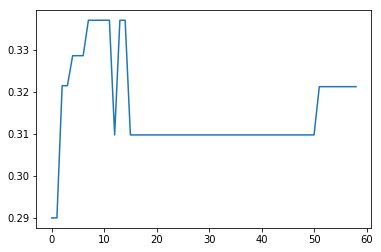

In [38]:
plt.plot(true_value_in_argmins)

In [39]:
observations_gp = pd.read_csv('data/observations_500_gp.csv').dropna()

true_value_in_argmins_gp = []

for n_i in np.arange(20, len(observations_gp)):
    
    binomial = GPy.likelihoods.Binomial()
    X_t = observations_ggpm[observations_ggpm.columns[:-3]].values[:n_i]
    Y_t = observations_ggpm[['reco_passed_no_clones']].values[:n_i]
    trials_t = observations_ggpm[['total']].values[:n_i]
    
    m_t = GPy.models.GPRegression(X_t, Y_t/trials_t, kernel=GPy.kern.RBF(7))
    m_t.optimize()
    
    argmax = X_t[np.argmax(m_t.predict(X_t)[0])].reshape(1, -1)
    true_value = binomial.gp_link.transf(t_f._raw_predict(argmax)[0][0][0])
    
    true_value_in_argmins_gp.append(true_value)

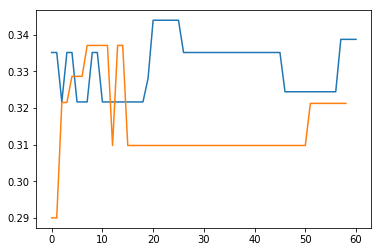

In [40]:
plt.plot(true_value_in_argmins_gp)
plt.plot(true_value_in_argmins)

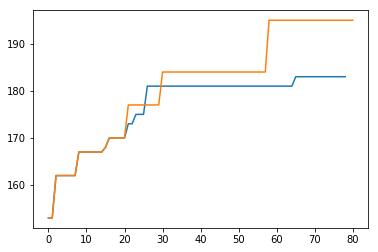

In [41]:
plt.plot(np.maximum.accumulate(observations_ggpm.reco_passed_no_clones))
plt.plot(np.maximum.accumulate(observations_gp.reco_passed_no_clones))